In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamadatef","key":"5a6fd90b61034369dd8b0c34f85c504e"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [01:03<00:00, 27.3MB/s]
100% 2.29G/2.29G [01:03<00:00, 38.6MB/s]


In [5]:
!ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [7]:
import pandas as pd
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

(1317, 1857, 3)


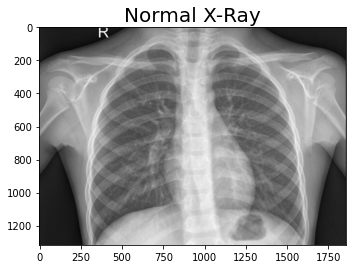

In [8]:
#normal x-ray example
xray_sample = '/content/files/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
xray_sample = np.asarray(cv.imread(xray_sample))
plt.title('Normal X-Ray', fontsize=20)
plt.imshow(xray_sample)
print(xray_sample.shape)

(762, 1106, 3)


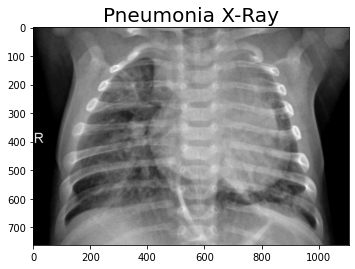

In [9]:
#pneumonia x-ray example
xray_sample = '/content/files/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
xray_sample = np.asarray(cv.imread(xray_sample))
plt.title('Pneumonia X-Ray', fontsize=20)
plt.imshow(xray_sample)
print(xray_sample.shape)

In [10]:
# Image Augmentation
from keras.preprocessing.image import ImageDataGenerator
dgen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)

In [11]:
#train, test, and validation data
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True) 
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    '/content/files/chest_xray/train',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    '/content/files/chest_xray/test',
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/files/chest_xray/val',
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary',
    seed=42
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
from keras import layers, models, optimizers

In [14]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) 
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 

model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 

#model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
#model.add(layers.MaxPooling2D((2, 2))) 

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [17]:
early = EarlyStopping(monitor='val_loss',
                      patience=3,
                      mode="min",
                      restore_best_weights=True,
                      verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                        patience=3,
                                        verbose=1,
                                        factor=0.5,
                                        min_lr=0.00001)

In [18]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=1, callbacks=[reduce_learning_rate, early])

Epoch 1/10
261/261 [==============================] - 113s 384ms/step - loss: 0.4927 - accuracy: 0.7665 - val_loss: 0.8567 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/10
261/261 [==============================] - 98s 376ms/step - loss: 0.3645 - accuracy: 0.8225 - val_loss: 0.5024 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/10
261/261 [==============================] - 97s 373ms/step - loss: 0.3186 - accuracy: 0.8583 - val_loss: 0.7446 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/10
261/261 [==============================] - 98s 377ms/step - loss: 0.2792 - accuracy: 0.8769 - val_loss: 0.4545 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/10
261/261 [==============================] - 100s 382ms/step - loss: 0.2598 - accuracy: 0.8928 - val_loss: 0.4209 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
261/261 [==============================] - 98s 377ms/step - loss: 0.2399 - accuracy: 0.8951 - val_loss: 0.6932 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/10
261/261 [==============================

In [19]:
# Test accuracy and loss
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3125552535057068
Test accuracy: 0.8766025900840759


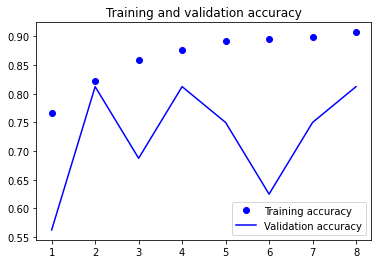

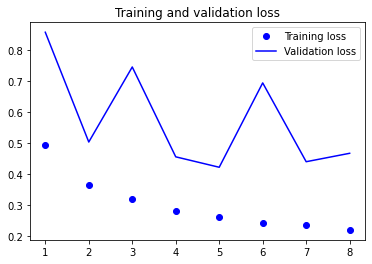

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy') 
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
#Transfer Learning using VGG16
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
# removing top and fully connected layers
model = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=(224, 224, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
#making the hidden layers non-trainable and adding new fully connected layers
for layer in model.layers:
  layer.trainable=False

from keras.layers import Dense, Activation, Dropout, Flatten

x = Flatten()(model.output)
x = Dense(512, activation='relu')(x)
prediction = Dense(1 ,activation='sigmoid')(x)

In [27]:
# Creating the model
from keras.models import Model
model = Model(inputs=model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [29]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=1, callbacks=[reduce_learning_rate, early])

Epoch 1/10
261/261 [==============================] - 112s 418ms/step - loss: 0.3814 - accuracy: 0.8712 - val_loss: 0.2416 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/10
261/261 [==============================] - 103s 393ms/step - loss: 0.1859 - accuracy: 0.9256 - val_loss: 0.5768 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
261/261 [==============================] - 102s 389ms/step - loss: 0.1577 - accuracy: 0.9377 - val_loss: 0.4857 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
261/261 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9417
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 1.
261/261 [==============================] - 101s 389ms/step - loss: 0.1464 - accuracy: 0.9417 - val_loss: 0.4694 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4: early stopping


In [30]:
# Test accuracy and loss
score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2491079717874527
Test accuracy: 0.8942307829856873


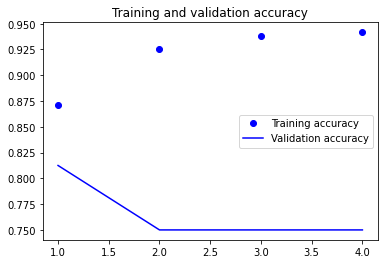

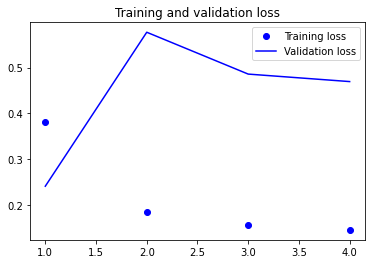

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy') 
plt.plot(epochs, val_acc, 'b', label='Validation accuracy') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()